In [3]:
import torch
import pyro
import pyro.distributions as dist
from chirho.observational.handlers import condition
import matplotlib.pyplot as plt

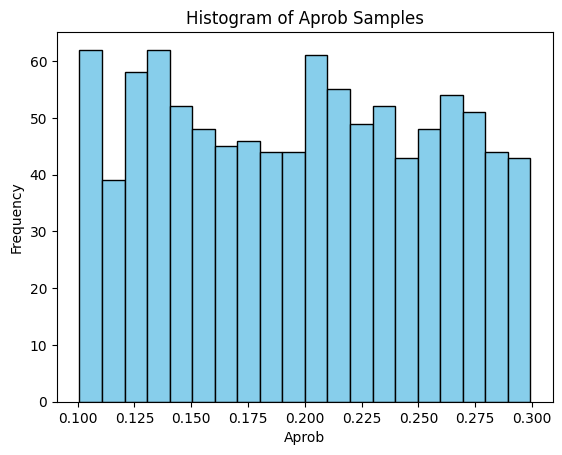

In [3]:
def sample_Aprob():
    return pyro.sample("Aprob", dist.Uniform(0.1, 0.3))

# Simulate 1000 samples of Aprob
samples_Aprob = [sample_Aprob().item() for _ in range(1000)]

# Plot the histogram of Aprob samples
plt.hist(samples_Aprob, bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Aprob')
plt.ylabel('Frequency')
plt.title('Histogram of Aprob Samples')
plt.show()

tensor(0.0100) tensor(0.0400) tensor(0.0900)


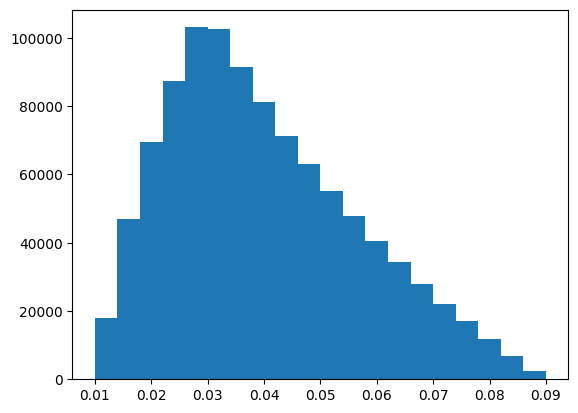

In [14]:
def imprecise_composition():
    Aprob = pyro.sample("Aprob", dist.Uniform(.1,.3))  # uniform dist from 0.1 to 0.3
    Bprob = pyro.sample("Bprob", dist.Uniform(.1,.3))
    Cprob = pyro.sample("Cprob", dist.Uniform(.1,.3))
    
    ABprob = pyro.deterministic("ABprob", Aprob * Bprob) # product of A and B 
    
# AB product: This triangular distribution arises because, when two independent variables are sampled uniformly, their product
# follows a distribution that's triangular in shape, with the peak density at the midpoint between the minimum and maximum possible values
    
    lh = pyro.deterministic("lh", 1/ABprob) 

    lh3 = pyro.deterministic("lh3", 1/(Aprob * Bprob * Cprob))

with pyro.poutine.trace() as prior: # poutine records the execution of the model
    with pyro.plate("prior", 100000): # declaration of a plate under a name 'prior' with 100000 samples
        imprecise_composition()









def imprecise_composition():
    Aprob = pyro.sample("Aprob", dist.Uniform(.1,.3))
    Bprob = pyro.sample("Bprob", dist.Uniform(.1,.3))
    
    ABprob = pyro.deterministic("ABprob", Aprob * Bprob)
    
    lh = pyro.deterministic("lh", 1/ABprob)

with pyro.poutine.trace() as prior:
    with pyro.plate("prior", 1000000):
        imprecise_composition()
 


lh = prior.trace.nodes['ABprob']['value']
print(torch.min(lh), torch.mean(lh), torch.max(lh))         # plot of 100 lh values
plt.hist(lh, bins=20)
plt.vlines(torch.mean(lh), 0, 150, color='r')
plt.show()


In [ ]:
with pyro.plate("testing_a_b", 1000):
    b = pyro.sample("b", dist.Beta(16,71))

print(torch.quantile(b, 0.01), torch.mean(b), torch.quantile(b, 0.99))
print(torch.pow(1/torch.mean(b),2))

In [ ]:
def beta_composition():
    Aprob = pyro.sample("Aprob", dist.Beta(16,71))
    Bprob = pyro.sample("Bprob", dist.Beta(16,71))
    
    ABprob = pyro.deterministic("ABprob", Aprob * Bprob)
    
    lh = pyro.deterministic("lh", 1/ABprob)
    
    single_lh = pyro.deterministic("single_lh", 1/Aprob)
    lh = pyro.deterministic("lh", 1/ABprob)
    
with pyro.poutine.trace() as prior:
    with pyro.plate("prior", 1000):
        beta_composition()

lh = prior.trace.nodes['lh']['value']
print(torch.quantile(lh, 0.01), torch.mean(lh), torch.quantile(lh, 0.99))
plt.hist(lh, bins=20)
plt.show()

In [21]:
def sample_alpha_beta():
    # Sample alpha and beta parameters from Bernoulli distributions
    alpha = pyro.sample("alpha", dist.Bernoulli(0.5)).item() + 1
    beta = pyro.sample("beta", dist.Bernoulli(0.5)).item() + 1
    
    return alpha, beta

# Test the function
alpha, beta = sample_alpha_beta()
print("Sampled alpha:", alpha)

Sampled alpha: 1.0


In [61]:
def normalize_vector(vector):
    return vector / torch.sum(vector)


def plot_normalized_histogram(lh):

    
    values = prior.trace.nodes[lh]['value']
    normalized_values = normalize_vector(values)
    

    quantile_01 = torch.quantile(normalized_values, 0.01).item()
    mean_value = torch.mean(normalized_values).item()
    quantile_99 = torch.quantile(normalized_values, 0.99).item()
    
    print("Quantile 0.01:", quantile_01)
    print("Mean:", mean_value)
    print("Quantile 0.99:", quantile_99)
    

    plt.hist(normalized_values, bins=20, range=(0, quantile_99 + 0.05), density=True, alpha=0.6, color='b', edgecolor='black')
    plt.xlabel('Normalized Likelihood Ratio')
    plt.ylabel('Probability Density')
    plt.axvline(x=quantile_01, color='r', linestyle='--', label='1st Percentile')
    plt.axvline(x=mean_value, color='g', linestyle='--', label='Mean')
    plt.axvline(x=quantile_99, color='m', linestyle='--', label='99th Percentile')
    plt.legend()
    plt.show()

In [28]:

p = 0.1 # SAMPLED from uniform distribution 0 - 0.2
bernoulli_dist = dist.Bernoulli(p)

samples = bernoulli_dist.sample(torch.Size([50])) # 50 samples

samples_tensor = torch.tensor(samples)

count_1s = torch.sum(samples_tensor).item() # counting the number of 1s
count_0s = samples_tensor.size(0) - count_1s

# IT SHOULD be a list of tuples (pairs used for creating beta distributions)


def beta_composition(): # BETA setup for a single a/b value
    Aprob = pyro.sample("Aprob", dist.Beta(count_1s, count_0s))
    Bprob = pyro.sample("Bprob", dist.Beta(count_1s, count_0s))
    Cprob = pyro.sample("Cprob", dist.Beta(count_1s, count_0s))
    
    single_lh = pyro.deterministic("single_lh", 1/Aprob)
    double_lh = pyro.deterministic("double_lh", 1/(Aprob * Bprob))
    triple_lh = pyro.deterministic("triple_lh", 1/(Aprob * Bprob * Cprob))
    
with pyro.poutine.trace() as prior:
    with pyro.plate("prior", 1000):
        beta_composition()


C:\Users\nikod\AppData\Local\Temp\ipykernel_324\1941977171.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  samples_tensor = torch.tensor(samples)


Quantile 0.01: 3.209065835108049e-05
Mean: 0.001000000280328095
Quantile 0.99: 0.010965033434331417


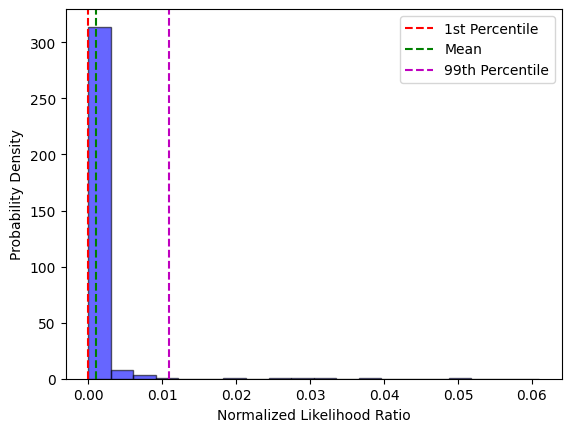

Quantile 0.01: 6.947465863049729e-06
Mean: 0.0009999999310821295
Quantile 0.99: 0.013356432318687439


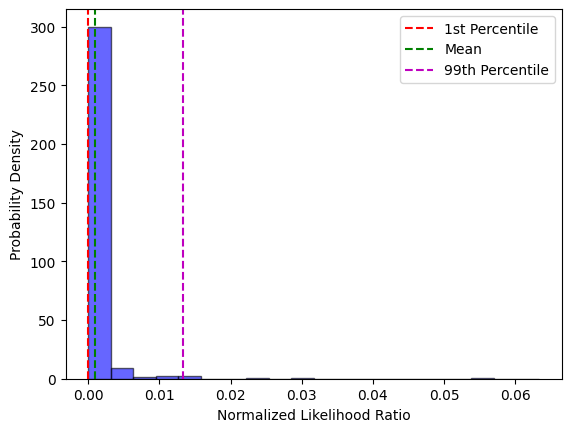

Quantile 0.01: 1.2813185321647325e-06
Mean: 0.0009999999310821295
Quantile 0.99: 0.017884083092212677


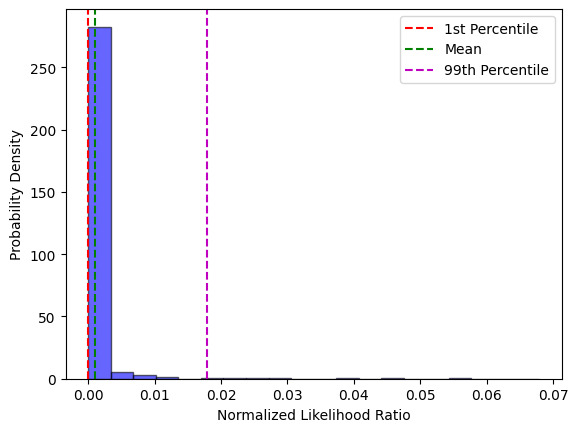

In [64]:
list_lh = ["single_lh", "double_lh", "triple_lh"]

for x in list_lh:

    plot_normalized_histogram(x)

Option with 0,1 evidence

In [84]:
def generate_data(num_samples, alpha, beta):
    # True hypothesis probabilities
    true_hypothesis_prob = pyro.sample("hyp", dist.Uniform(0, 0.2).expand([num_samples]))


    # Generate evidence probabilities from Beta distributions
    Aprob = pyro.sample("Aprob", dist.Beta(alpha, beta))
    Bprob = pyro.sample("Bprob", dist.Beta(alpha, beta))
    Cprob = pyro.sample("Cprob", dist.Beta(alpha, beta))
    
    single_lh = 1/Aprob
    double_lh = 1/(Aprob * Bprob)
    triple_lh = 1/(Aprob * Bprob * Cprob)
    
    # Generate truth values of the hypothesis for each setting
    single_evidence_truth = (torch.rand(num_samples) < true_hypothesis_prob).float()
    double_evidence_truth = (torch.rand(num_samples) < true_hypothesis_prob).float()
    triple_evidence_truth = (torch.rand(num_samples) < true_hypothesis_prob).float()

    # Adding noise to simulate imprecision
    single_evidence = (torch.rand(num_samples) < single_lh).float()
    double_evidence = (torch.rand(num_samples) < double_lh).float()
    triple_evidence = (torch.rand(num_samples) < triple_lh).float()

    return true_hypothesis_prob, single_evidence_truth, double_evidence_truth, triple_evidence_truth, single_evidence, double_evidence, triple_evidence



def evaluate_performance(true_hypothesis_prob, single_evidence_truth, double_evidence_truth, triple_evidence_truth, single_evidence, double_evidence, triple_evidence):
    
    
    single_likelihood_ratio = single_evidence / true_hypothesis_prob # likelihood ratios
    double_likelihood_ratio = double_evidence / true_hypothesis_prob
    triple_likelihood_ratio = triple_evidence / true_hypothesis_prob

    threshold = 1000
    single_decision = (single_likelihood_ratio > threshold).float()
    double_decision = (double_likelihood_ratio > threshold).float()
    triple_decision = (triple_likelihood_ratio > threshold).float()

    # confusion matrices
    single_confusion_matrix = torch.zeros(2, 2)
    double_confusion_matrix = torch.zeros(2, 2)
    triple_confusion_matrix = torch.zeros(2, 2)

    single_confusion_matrix[0, 0] = torch.sum((single_decision == 0) & (single_evidence_truth == 0))
    single_confusion_matrix[0, 1] = torch.sum((single_decision == 0) & (single_evidence_truth == 1))
    single_confusion_matrix[1, 0] = torch.sum((single_decision == 1) & (single_evidence_truth == 0))
    single_confusion_matrix[1, 1] = torch.sum((single_decision == 1) & (single_evidence_truth == 1))

    double_confusion_matrix[0, 0] = torch.sum((double_decision == 0) & (double_evidence_truth == 0))
    double_confusion_matrix[0, 1] = torch.sum((double_decision == 0) & (double_evidence_truth == 1))
    double_confusion_matrix[1, 0] = torch.sum((double_decision == 1) & (double_evidence_truth == 0))
    double_confusion_matrix[1, 1] = torch.sum((double_decision == 1) & (double_evidence_truth == 1))

    triple_confusion_matrix[0, 0] = torch.sum((triple_decision == 0) & (triple_evidence_truth == 0))
    triple_confusion_matrix[0, 1] = torch.sum((triple_decision == 0) & (triple_evidence_truth == 1))
    triple_confusion_matrix[1, 0] = torch.sum((triple_decision == 1) & (triple_evidence_truth == 0))
    triple_confusion_matrix[1, 1] = torch.sum((triple_decision == 1) & (triple_evidence_truth == 1))

    return single_confusion_matrix, double_confusion_matrix, triple_confusion_matrix

In [85]:
alpha = []
beta = []

for _ in range(100):
    counts = []
    for _ in range(50):
        count_1 = pyro.sample("count_1", dist.Bernoulli(0.1))
        counts.append(count_1.item())

    count_1 = counts.count(1)
    count_0 = counts.count(0)

    alpha.append(count_1)
    beta.append(count_0)

In [92]:
num_samples = 1000
true_hypothesis_prob, single_evidence_truth, double_evidence_truth, triple_evidence_truth, single_evidence, double_evidence, triple_evidence = generate_data(num_samples, alpha[0], beta[0])

single_confusion_matrix, double_confusion_matrix, triple_confusion_matrix = evaluate_performance(true_hypothesis_prob, single_evidence_truth, double_evidence_truth, triple_evidence_truth, single_evidence, double_evidence, triple_evidence)

print("Single evidence confusion matrix:")
print(single_confusion_matrix)
print("\nDouble evidence confusion matrix:")
print(double_confusion_matrix)
print("\nTriple evidence confusion matrix:")
print(triple_confusion_matrix)

ValueError: not enough values to unpack (expected 7, got 4)